## Zuber

#### 1. Introduction 

This notebook works with two datasets that contain information for ride services in the Chicago Area in the month of Nov. 2017, with some specific data for Nov. 15-16, 2017. This is a cursory glance at the data to determine the top ten companies that provided the most rides and the likewise destination neighborhoods. These findings will be bolstered by data visualization and exploratory analysis.

##### 1.2 Initialization

In [152]:
# Import libraries that might be necessary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind

# Import DataFrams
    #DataFraame with company name and total rides
comp_count_trip = 'https://raw.githubusercontent.com/DHE42/zuber/refs/heads/main/moved_project_sql_result_01.csv'
comp_count_trip_df = pd.read_csv(comp_count_trip)

    #DataFrame with both destination and corresponding ride average
dropoff_trip_avg = 'https://raw.githubusercontent.com/DHE42/zuber/refs/heads/main/moved_project_sql_result_04.csv'
dropoff_trip_avg_df = pd.read_csv(dropoff_trip_avg)

    #DataFrame with date, weather, and ride duration for Nov. 2017
loop_ohare = 'https://raw.githubusercontent.com/DHE42/zuber/refs/heads/main/moved_project_sql_result_07.csv'
loop_ohare_df = pd.read_csv(loop_ohare)


Above, I have imported necessary libraries and the three datasets I'll be working with. Below, I will review the data.

#### 2. Data Review

##### 2.1 Review of comp_count_trip_df 

In [153]:
# Review  comp_count_trip_df
    #Data Head
print("Head of comp_count_trip_df")
print()
print(comp_count_trip_df.head())
print()

    #Data Info
print("Info of comp_count_trip_df")
print()
print(comp_count_trip_df.info())
print()

    #Data Description
print("Description of comp_count_trip_df")
print()
print(comp_count_trip_df.describe())
print()

    #Null Values
print("Null values in comp_count_trip_df")
print()
print(comp_count_trip_df.isnull().sum())
print()

    #Duplicate Rows
print("Duplicates in comp_count_trip_df")
print()
print(comp_count_trip_df.duplicated().sum())
print()




Head of comp_count_trip_df

                      company_name  trips_amount
0                        Flash Cab         19558
1        Taxi Affiliation Services         11422
2                 Medallion Leasin         10367
3                       Yellow Cab          9888
4  Taxi Affiliation Service Yellow          9299

Info of comp_count_trip_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None

Description of comp_count_trip_df

       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000

Null values in comp_count_trip_df

company_name    0
trips_amount    0
dtype: int64

Duplicates in comp_cou

The 'company_name' column displays the name of the ride company, and 'trips_amount' displays the number of rides the service has given. The first thing that jumps out to me in the head of the data is the lack of standardization. To start, I will rename column 'company_name' to 'company'. Then I will convert the object dtype values in 'company' into string dtype and snake case, make sure they are all lower case, and then perform the requisite data cleaning operations such as removing heading or tailing spaces, etc. I will also rename the 'trips_amount' column 'trip_sum' for simplicity and accuracy. The data types for the trips appear to be appropriate, as one column is categorical and the other is numerical sans decimal precision necessity since there is no such thing as a partial trip. Separately calling the null values and duplicate rows confirms the lack of these types of data errors as originally shown using the describe() function. With a mean of about 2,145, a standard deviation of of about 3,812, and a median of 178, it is obvious that there is high variability in the dataset, and that the median is likely the best representation of ride company performance during the two days of November 15-16, 2017.

#### 2.2 Review of dropoff_avg_trip_df

In [154]:
# Review dropoff_trip_avg

    #Data Head
print("Head of dropoff_trip_avg")
print(dropoff_trip_avg_df.head())
print()

    #Data Info
print("Info of dropoff_trip_avg")
print()
print(dropoff_trip_avg_df.info())
print()

    #Data Description
print("Description of dropoff_trip_avg")
print()
print(dropoff_trip_avg_df.describe())
print()

    #Null Values
print("Null values in dropoff_trip_avg")
print()
print(dropoff_trip_avg_df.isnull().sum())
print()

    #Duplicate Rows
print("Duplicates in dropoff_trip_avg")
print()
print(dropoff_trip_avg_df.duplicated().sum())
print()

Head of dropoff_trip_avg
  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000

Info of dropoff_trip_avg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None

Description of dropoff_trip_avg

       average_trips
count      94.000000
mean      599.953728
std      1714.591098
min         1.800000
25%        14.266667
50%        52.016667
75%       298.858333
max     10727.466667

Null values in dropoff_trip_avg

dropoff_location_name    0
average_trips            0
dtype: int64

Duplicates in dropoff_

This is extremely similar data to the previous DataFrame. The column 'dropoff_location_name' corresponds to a neighborhood that is the destination of the ride service, and 'average_trips' refers to the mean of how many times ride ended in that neighborhood. I will begin with the aforementioned usual step of value standardization. Then, I'll rename the categorical column 'destination' and the numerical column 'trip_average'. The dtypes are correct for a string and numerical decimal precision, respectively. Since this DataFrame measures averages, it is permissible for the numerical values to contain floats for precision's sake. However, decimal places after the hundredths spot are superfluous. Separately calling functions to find null values and duplicate rows confirms the conclusion that these data gaps don't exist, which was first confirmed from calling the info() and describe() functions. As with the previous dataset, it is obvious that there are significant outliers and high variability.  

#### 2.3 Review of loop_ohare_df

In [155]:
# Review loop_ohare_df

   #Data Head
print("Head of loop_ohare_df")
print(loop_ohare_df.head())
print()

   #Data Info
print("Info of loop_ohare_df")
print()
print(loop_ohare_df.info())
print()

   #Data Description
print("Description of loop_ohare_df")
print()
print(loop_ohare_df.describe())
print()
   #Null Values
print("Null values in loop_ohare_df")
print()
print(loop_ohare_df.isnull().sum())
print()

   #Duplicate Rows
print("Duplicates in loop_ohare_df")
print()
print(loop_ohare_df.duplicated().sum())


Head of loop_ohare_df
              start_ts weather_conditions  duration_seconds
0  2017-11-25 16:00:00               Good            2410.0
1  2017-11-25 14:00:00               Good            1920.0
2  2017-11-25 12:00:00               Good            1543.0
3  2017-11-04 10:00:00               Good            2512.0
4  2017-11-11 07:00:00               Good            1440.0

Info of loop_ohare_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB
None

Description of loop_ohare_df

       duration_seconds
count       1068.000000
mean        2071.731273
std          769.461125
min            0.000000
25%         1438.250000
50%       

Column 'start_ts' displays the start date and time of the ride, 'weather_conditions' displays if the weather was good or bad, and 'duration_seconds' displays how many seconds the whole trip lasted. The loop_ohare_df has some more immediate issues besides simple string standardization. Firstly, 'start_ts' will be renamed 'start_time', 'weather_conditions' will simply be renamed 'weather', and 'duration_seconds' will be renamed 'trip_length'. Column 'start_time' will then be converted to datetime format, 'weather' will be cleaned, and 'trip_length' will be divided by 60 to show minutes, as this is better for visual storytelling, as well as more readily intelligible. Calling isnull() shows that there are no null values in the columns, however it appears there are 197 duplicate rows in loop_ohare_df. While there should be similar data for rides, it is highly unlikely that there is any completely identical data. Therefore, the duplicates can be dropped.


#### 3. Data Cleaning

##### 3.1 Cleaning comp_count_trip_df

Steps to clean comp_count_trip_df:

1) Rename Columns
2) Convert Data Types
3) Clean 'company'
4) Call Head to Confirm Changes

In [156]:
# Renaming Columns

    # Rename 'company_name' to 'company' and 'trip_amounts' to 'trip_sum'
comp_count_trip_df.rename(columns={'company_name': 'company', 'trips_amount': 'trip_sum'}, inplace=True)

# Dtype Conversion
   
    # Convert 'company' to string
comp_count_trip_df['company'] = comp_count_trip_df['company'].astype('str')

# Cleaning the 'company' column

    # Remove leading and trailing spaces
comp_count_trip_df['company'] = comp_count_trip_df['company'].str.strip()

    # Replace ampersand with 'and'
comp_count_trip_df['company'] = comp_count_trip_df['company'].str.replace('&', 'and')

    # Remove periods, commas, hyphens, and apostraphes
comp_count_trip_df['company'] = comp_count_trip_df['company'].str.replace(r'[.,\'-]', '', regex=True)

    # Convert to lowercase
comp_count_trip_df['company'] = comp_count_trip_df['company'].str.lower()

# Replace spaces with underscores
comp_count_trip_df['company'] = comp_count_trip_df['company'].str.replace(' ', '_')

# Call head to confirm changes
print("Head of comp_count_trip_df after cleaning")
print()
print(comp_count_trip_df.head())

        

Head of comp_count_trip_df after cleaning

                           company  trip_sum
0                        flash_cab     19558
1        taxi_affiliation_services     11422
2                 medallion_leasin     10367
3                       yellow_cab      9888
4  taxi_affiliation_service_yellow      9299


##### 3.2 Cleaning dropoff_avg_trip_df

Steps to clean dropoff_avg_trip_df:

1) Rename columns
2) Replace opaque neighborhood names with clear neighborhood names
3) Round to hundredths place in categorical column

In [157]:
# Rename Columns

    # Rename 'dropoff_location_name' to 'destinatin' and 'average_trips' to 'trip_average
dropoff_trip_avg_df.rename(columns={'dropoff_location_name': 'destination', 'average_trips': 'trip_average'}, inplace=True)

# Dtype Conversion
    # Convert 'destination' to string
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].astype('str')

# Cleaning the 'destination' column
    
    # Remove leading and trailing spaces
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.strip()
    
    # Convert to lowercase
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.lower()
    
    # Replace spaces with underscores
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.replace(' ', '_')
    
    # Replace ampersands with 'and'
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.replace('&', 'and')
    
    # Replace 'sauganash,forest_glen' with 'forest_glen'
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.replace('sauganash,forest_glen', 'forest_glen')

    # Replace 'o'hare' with 'ohare'
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.replace("o'hare", 'ohare')

    # Replace 'little_italy,_uic' with 'little_italy'
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.replace('little_italy,_uic', 'little_italy')

    # Replace 'undef' with 'undefined'
dropoff_trip_avg_df['destination'] = dropoff_trip_avg_df['destination'].str.replace('undef', 'undefined')

# Round 'trip_avg' to hundredths spot
dropoff_trip_avg_df['trip_average'] = dropoff_trip_avg_df['trip_average'].round(2)

# Print the head of the DataFrame to confirm changes
print("Head of dropoff_trip_avg_df after cleaning")
print()
print(dropoff_trip_avg_df.head())

# Test for duplicates
    # Check for duplicates in 'destination' column

Head of dropoff_trip_avg_df after cleaning

     destination  trip_average
0           loop      10727.47
1    river_north       9523.67
2  streeterville       6664.67
3      west_loop       5163.67
4          ohare       2546.90


##### 3.3 Cleaning loop_ohare_df

Steps to clean loop_ohare_df:

1) Rename columns
2) Convert data types
3) Drop duplicate rows

In [158]:
# Rename Columns
    # Rename 'start_ts' to 'start_time, 'weather_conditions' to 'weather', and 'duration_seconds' to 'trip_length'
loop_ohare_df.rename(columns={'start_ts': 'start_time', 'weather_conditions': 'weather', 'duration_seconds': 'trip_length'}, inplace=True)

# Dtype Conversion
    # Convert 'start_time' to datetime
loop_ohare_df['start_time'] = pd.to_datetime(loop_ohare_df['start_time'], format='%Y-%m-%d %H:%M:%S')
    # Convert 'weather' to string
loop_ohare_df['weather'] = loop_ohare_df['weather'].astype('str')
    
    

# Cleaning the 'weather' column
    # Remove leading and trailing spaces
loop_ohare_df['weather'] = loop_ohare_df['weather'].str.strip()

    # Convert to lowercase
loop_ohare_df['weather'] = loop_ohare_df['weather'].str.lower()

    # Replace spaces with underscores
loop_ohare_df['weather'] = loop_ohare_df['weather'].str.replace(' ', '_')

# Cleaning the 'trip_length' column
    # Divide 'trip_length' by 60 to convert seconds to minutes
loop_ohare_df['trip_length'] = loop_ohare_df['trip_length'] / 60
    # Round 'trip_length' to hundredths spot
loop_ohare_df['trip_length'] = loop_ohare_df['trip_length'].round(2)


# Drop duplicates
loop_ohare_df.drop_duplicates(inplace=True)

# Print the head of the DataFrame to confirm changes
print("Head of loop_ohare_df after cleaning")
print()
print(loop_ohare_df.head())
print()

#Duplicate Rows
print("Duplicates in loop_ohare_df")
print()
print(loop_ohare_df.duplicated().sum())

Head of loop_ohare_df after cleaning

           start_time weather  trip_length
0 2017-11-25 16:00:00    good        40.17
1 2017-11-25 14:00:00    good        32.00
2 2017-11-25 12:00:00    good        25.72
3 2017-11-04 10:00:00    good        41.87
4 2017-11-11 07:00:00    good        24.00

Duplicates in loop_ohare_df

0


#### 4. Exploratory Data Analysis and Data Visualization

Let's do some visualization to find out the the top ten companies who give the most rides, and the top ten ride service destinations. Since trip_average displays the mean, there will be decimals. However, it is important to consider that there is no such thing as a partial ride to the destination. It is completed or not. Therefore, the top ten will be coerced and converted to the integer dtype.

In [159]:
# Find the top ten companies in comp_count_trip_df with the most rides
top_ten_companies = comp_count_trip_df.nlargest(10, 'trip_sum')
print("Ten Companies With Highest Usage")
print()
print(top_ten_companies)
print()

# Top ten destinations
    # Find the top ten destinations in dropoff_trip_avg_df with highest mean in 'trip_average'
top_ten_destinations = dropoff_trip_avg_df.nlargest(10, 'trip_average').astype({'trip_average': 'int'})

print("Ten Destinations With Highest Usage")
print()
print(top_ten_destinations)
print()

    

Ten Companies With Highest Usage

                            company  trip_sum
0                         flash_cab     19558
1         taxi_affiliation_services     11422
2                  medallion_leasin     10367
3                        yellow_cab      9888
4   taxi_affiliation_service_yellow      9299
5         chicago_carriage_cab_corp      9181
6                      city_service      8448
7                          sun_taxi      7701
8         star_north_management_llc      7455
9  blue_ribbon_taxi_association_inc      5953

Ten Destinations With Highest Usage

            destination  trip_average
0                  loop         10727
1           river_north          9523
2         streeterville          6664
3             west_loop          5163
4                 ohare          2546
5             lake_view          2420
6            grant_park          2068
7         museum_campus          1510
8            gold_coast          1364
9  sheffield_and_depaul          1259



With the top ten most used companies and top ten most popular destinations above, let's create two separate graphs. One will show total number of rides by taxi company, and the other will show top ten neighborhoods by number of dropoffs.

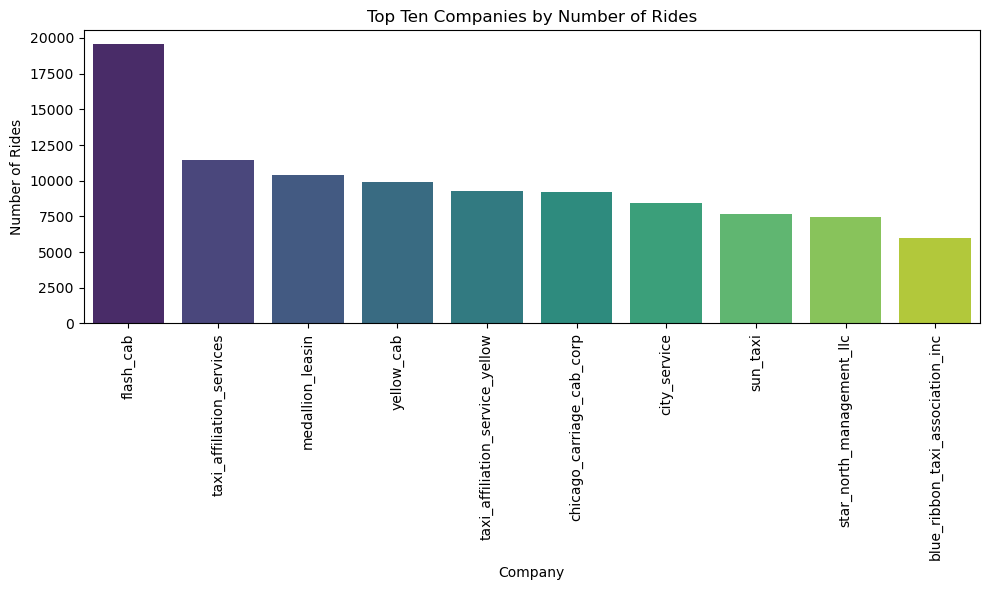


           trip_sum
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000


In [160]:
# Write a bar graph displaying number of rides for each company

plt.figure(figsize=(10, 6))
sns.barplot(x='company', y='trip_sum', data=top_ten_companies, palette='viridis', hue='company')
plt.title('Top Ten Companies by Number of Rides')
plt.xlabel('Company')
plt.ylabel('Number of Rides')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('total_rides.png')
plt.show()
print()


print(comp_count_trip_df.describe())

Flash Cab definitely leads the pack with 19558 rides overall for the 15th and 16th of Nov., 2017. It is a definite outlier that gives everything a right skew. In fact, all ten companies lay outside of the interquartile range, spiking up the mean of the data to the 75th percentile. The top ten companies do so incredibly well that it inflates the performance when only looking at the mean, but it is a truer statement that the grand majority of companies likely average closer to more or less 200 rides.

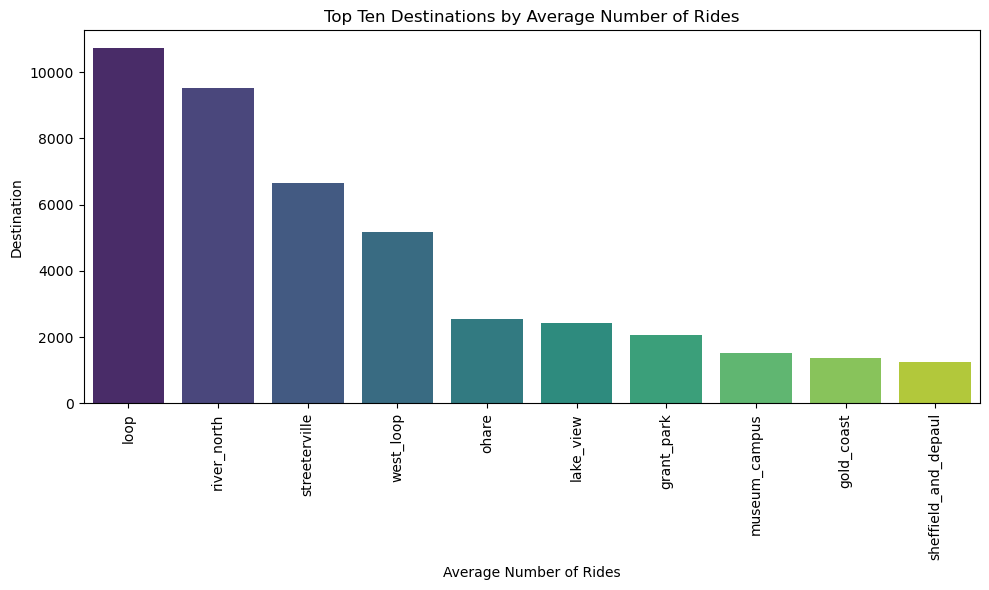


       trip_average
count     94.000000
mean     599.953830
std     1714.591706
min        1.800000
25%       14.265000
50%       52.015000
75%      298.855000
max    10727.470000


In [161]:
 # Write a bar graph displaying average rides for each destination
plt.figure(figsize=(10, 6))
sns.barplot(x='destination', y='trip_average', data=top_ten_destinations, palette='viridis', hue='destination')
plt.title('Top Ten Destinations by Average Number of Rides')
plt.xlabel('Average Number of Rides')
plt.ylabel('Destination')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('average_rides.png')
plt.show()
print()

print(dropoff_trip_avg_df.describe())


The Loop neighborhood is the most popular destination, with about 10,730 dropoffs. Again, it's likely that the other neighborhoods in the Chicago Area averaged closer to 50 dropoffs a night rather than the mean, which is inflated by the top ten.

#### 5. Weather Hypotheses

Let's test the hypothesis that the average duration of rides from Loop to O'Hare International Airport changes on rainy Saturdays. We'll need to first finding the mean of all Saturday dates with 'good' in the 'weather' column, then perform the operation with Saturdays that have 'bad' in the 'weather' column. From there, we can perform a t-test.

In [162]:
# Write a function to loop through the data every 7 days starting on 11/4/2017, and find the seperate means for 'trip_average' that correspond to the 'good' and 'bad' values in the 'weather' column separately
def calculate_means(df, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Select individual days every 7 days (e.g., all Saturdays in range)
    date_range = pd.date_range(start=start_date, end=end_date, freq='7D')

    good_means = []
    bad_means = []

    for day in date_range:
        # Keep only rows from that exact day
        mask = df['start_time'].dt.date == day.date()
        day_data = df[mask]

        # Calculate means for good and bad weather
        good_mean = day_data[day_data['weather'] == 'good']['trip_length'].mean()
        bad_mean = day_data[day_data['weather'] == 'bad']['trip_length'].mean()

        good_means.append(good_mean)
        bad_means.append(bad_mean)

    return good_means, bad_means
# Call the function with the DataFrame and date range
start_date = '2017-11-04'
end_date = '2017-11-25'
good_means, bad_means = calculate_means(loop_ohare_df, start_date, end_date)
# Create a DataFrame to store the results
means_df = pd.DataFrame({
    'Date': pd.date_range(start=start_date, end=end_date, freq='7D'),
    'Good_Weather_Mean': good_means,
    'Bad_Weather_Mean': bad_means
})
# Print the means DataFrame
print("Means DataFrame")
print()
print(means_df)
print()

Means DataFrame

        Date  Good_Weather_Mean  Bad_Weather_Mean
0 2017-11-04          38.189132         43.900000
1 2017-11-11          30.666266               NaN
2 2017-11-18          36.488767         37.670225
3 2017-11-25          31.441630               NaN



It appears that on the fourth and eighteenth there was both good and bad weather. Interesting! I'll set an alpha value of 0.05 simply ecause it's standard and there's no reason for stricter evidence in this case. The null hypothesis is that rain doesn't affect the average ride duration on Saturdays, whereas the alternative hypothesis is that it does. If the null hypothesis is true, then that means that the ride duration for both rainy and non-rainy Saturdays will average out the same. In the converse, the truth of the alternative hypothesis would indicate the means are not equal.

In [163]:
# Filter the data for Saturdays
saturday_data = loop_ohare_df[loop_ohare_df['start_time'].dt.dayofweek == 5]

# Group by weather condition
rainy = saturday_data[saturday_data['weather'] == 'bad']['trip_length']
non_rainy = saturday_data[saturday_data['weather'] == 'good']['trip_length']

# Perform independent t-test
t_stat, p_value = ttest_ind(rainy, non_rainy, equal_var=False)  # Welch's t-test is safer if variances differ

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Evaluate against alpha
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Rain affects trip duration on Saturdays.")
else:
    print("Fail to reject the null hypothesis: No evidence that rain affects trip duration on Saturdays.")

T-statistic: 5.531883449607667
P-value: 9.130263845385852e-08
Reject the null hypothesis: Rain affects trip duration on Saturdays.


The p-value is greater than 0.05 (By a long-shot!), meaning that the effect of the rain is statistically significant. Therefore, we must reject the null hypothesis that rain **does not effect** ride duration. It must be kept in mind that, statistically speaking, we cannot **totally embrace** the alternative hypothesis. However, it gives a satisfactory answer in terms of binary logic.

#### 5. Conclusions

It appears that the top ten contenders for both ride services and destinations significantly throw off the mean of the data, indicating that they are extremely high-performing. Therefore, it is prudent to focus resources on corresponding neighborhoods for likewise popular ride services in order to capitalize on demand and change customer loyalty. The t-test results suggest that rain makes the average trip duration longer during rainy weather. This is a common sense, yet key, insight that will help Zuber to strategically lower their prices on rainy days during the first few years, and even perhaps keep them low in order to increase customer loyalty so that the market rate for ride sharing is stable, thus ensuring return business as cab prices likely increase.